In [17]:
from utils import load_data, load_wisp_region
from nmf_beta import vectorize_data, transform2D
import numpy as np
DETECTOR, FILTER = 'nrcb4', 'F150W'
cal, err, bg, mask, meta = load_data(f'cache/{DETECTOR}_{FILTER}_data.fits')
wisp_region = load_wisp_region(f'cache/{DETECTOR}_{FILTER}_wisp_regions.fits')

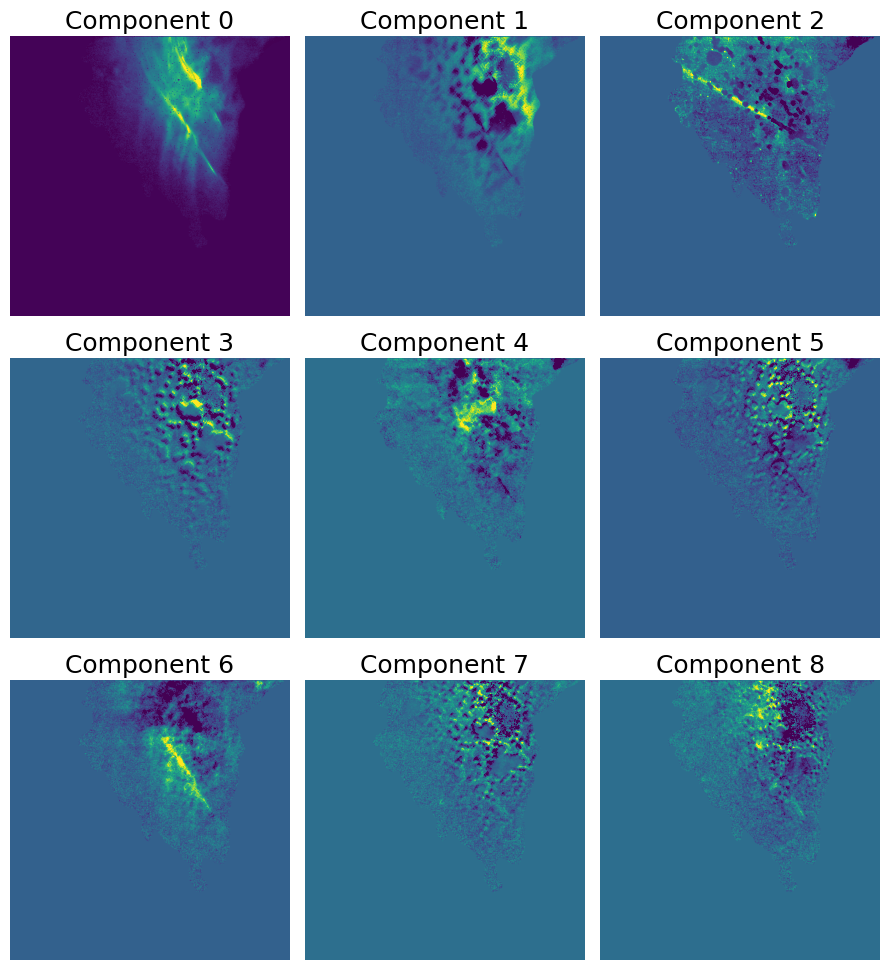

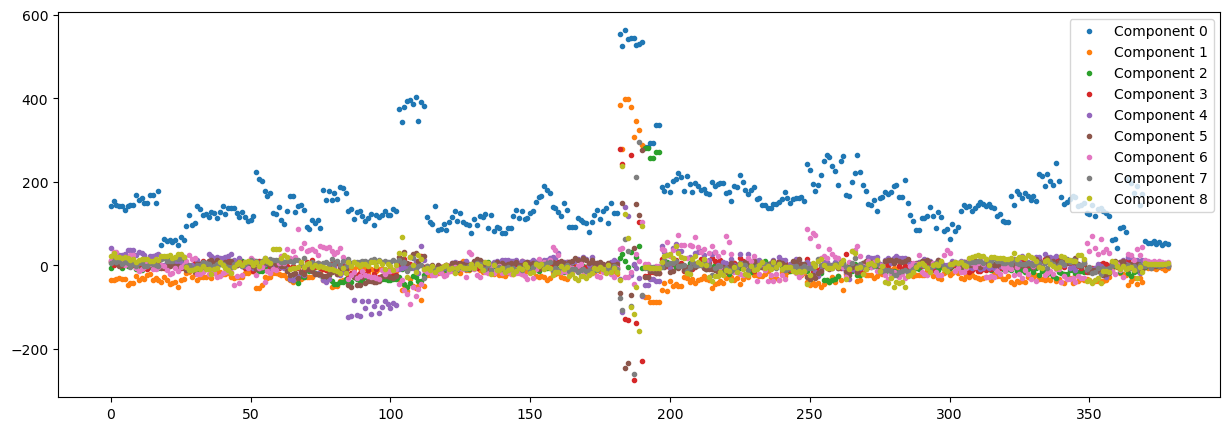

In [18]:
from utils import plot_comps, plot_amps, pca
amps, comps = pca(cal, err, mask, wisp_region)

plot_comps(comps)
plot_amps(amps, None);

[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]


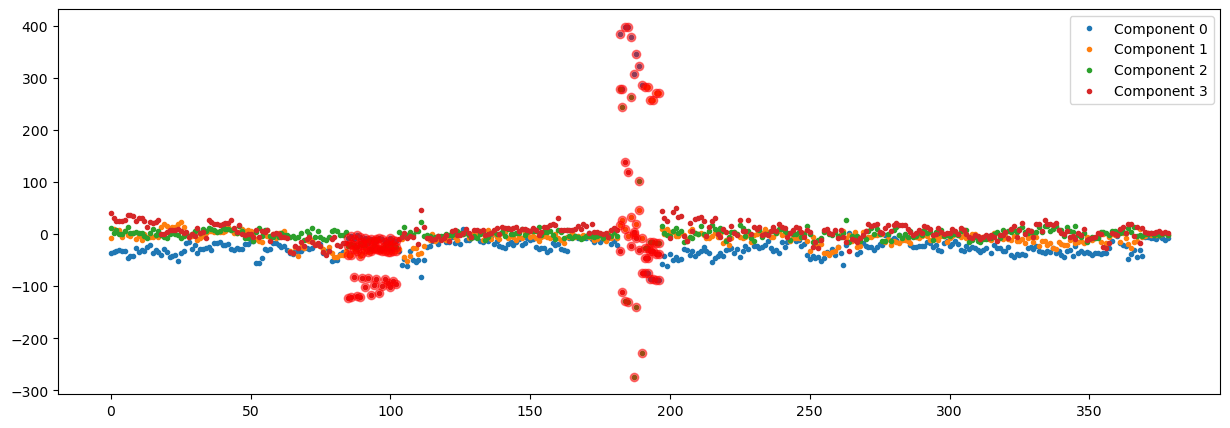

In [19]:
from nmf import identify_outliers
idx_artifacts = [1, 2, 3, 4]  # Example indices of artifacts
outliers = identify_outliers(amps[:, idx_artifacts], std_threshold=5)
print(outliers)
plot_amps(amps[:, idx_artifacts], outliers);

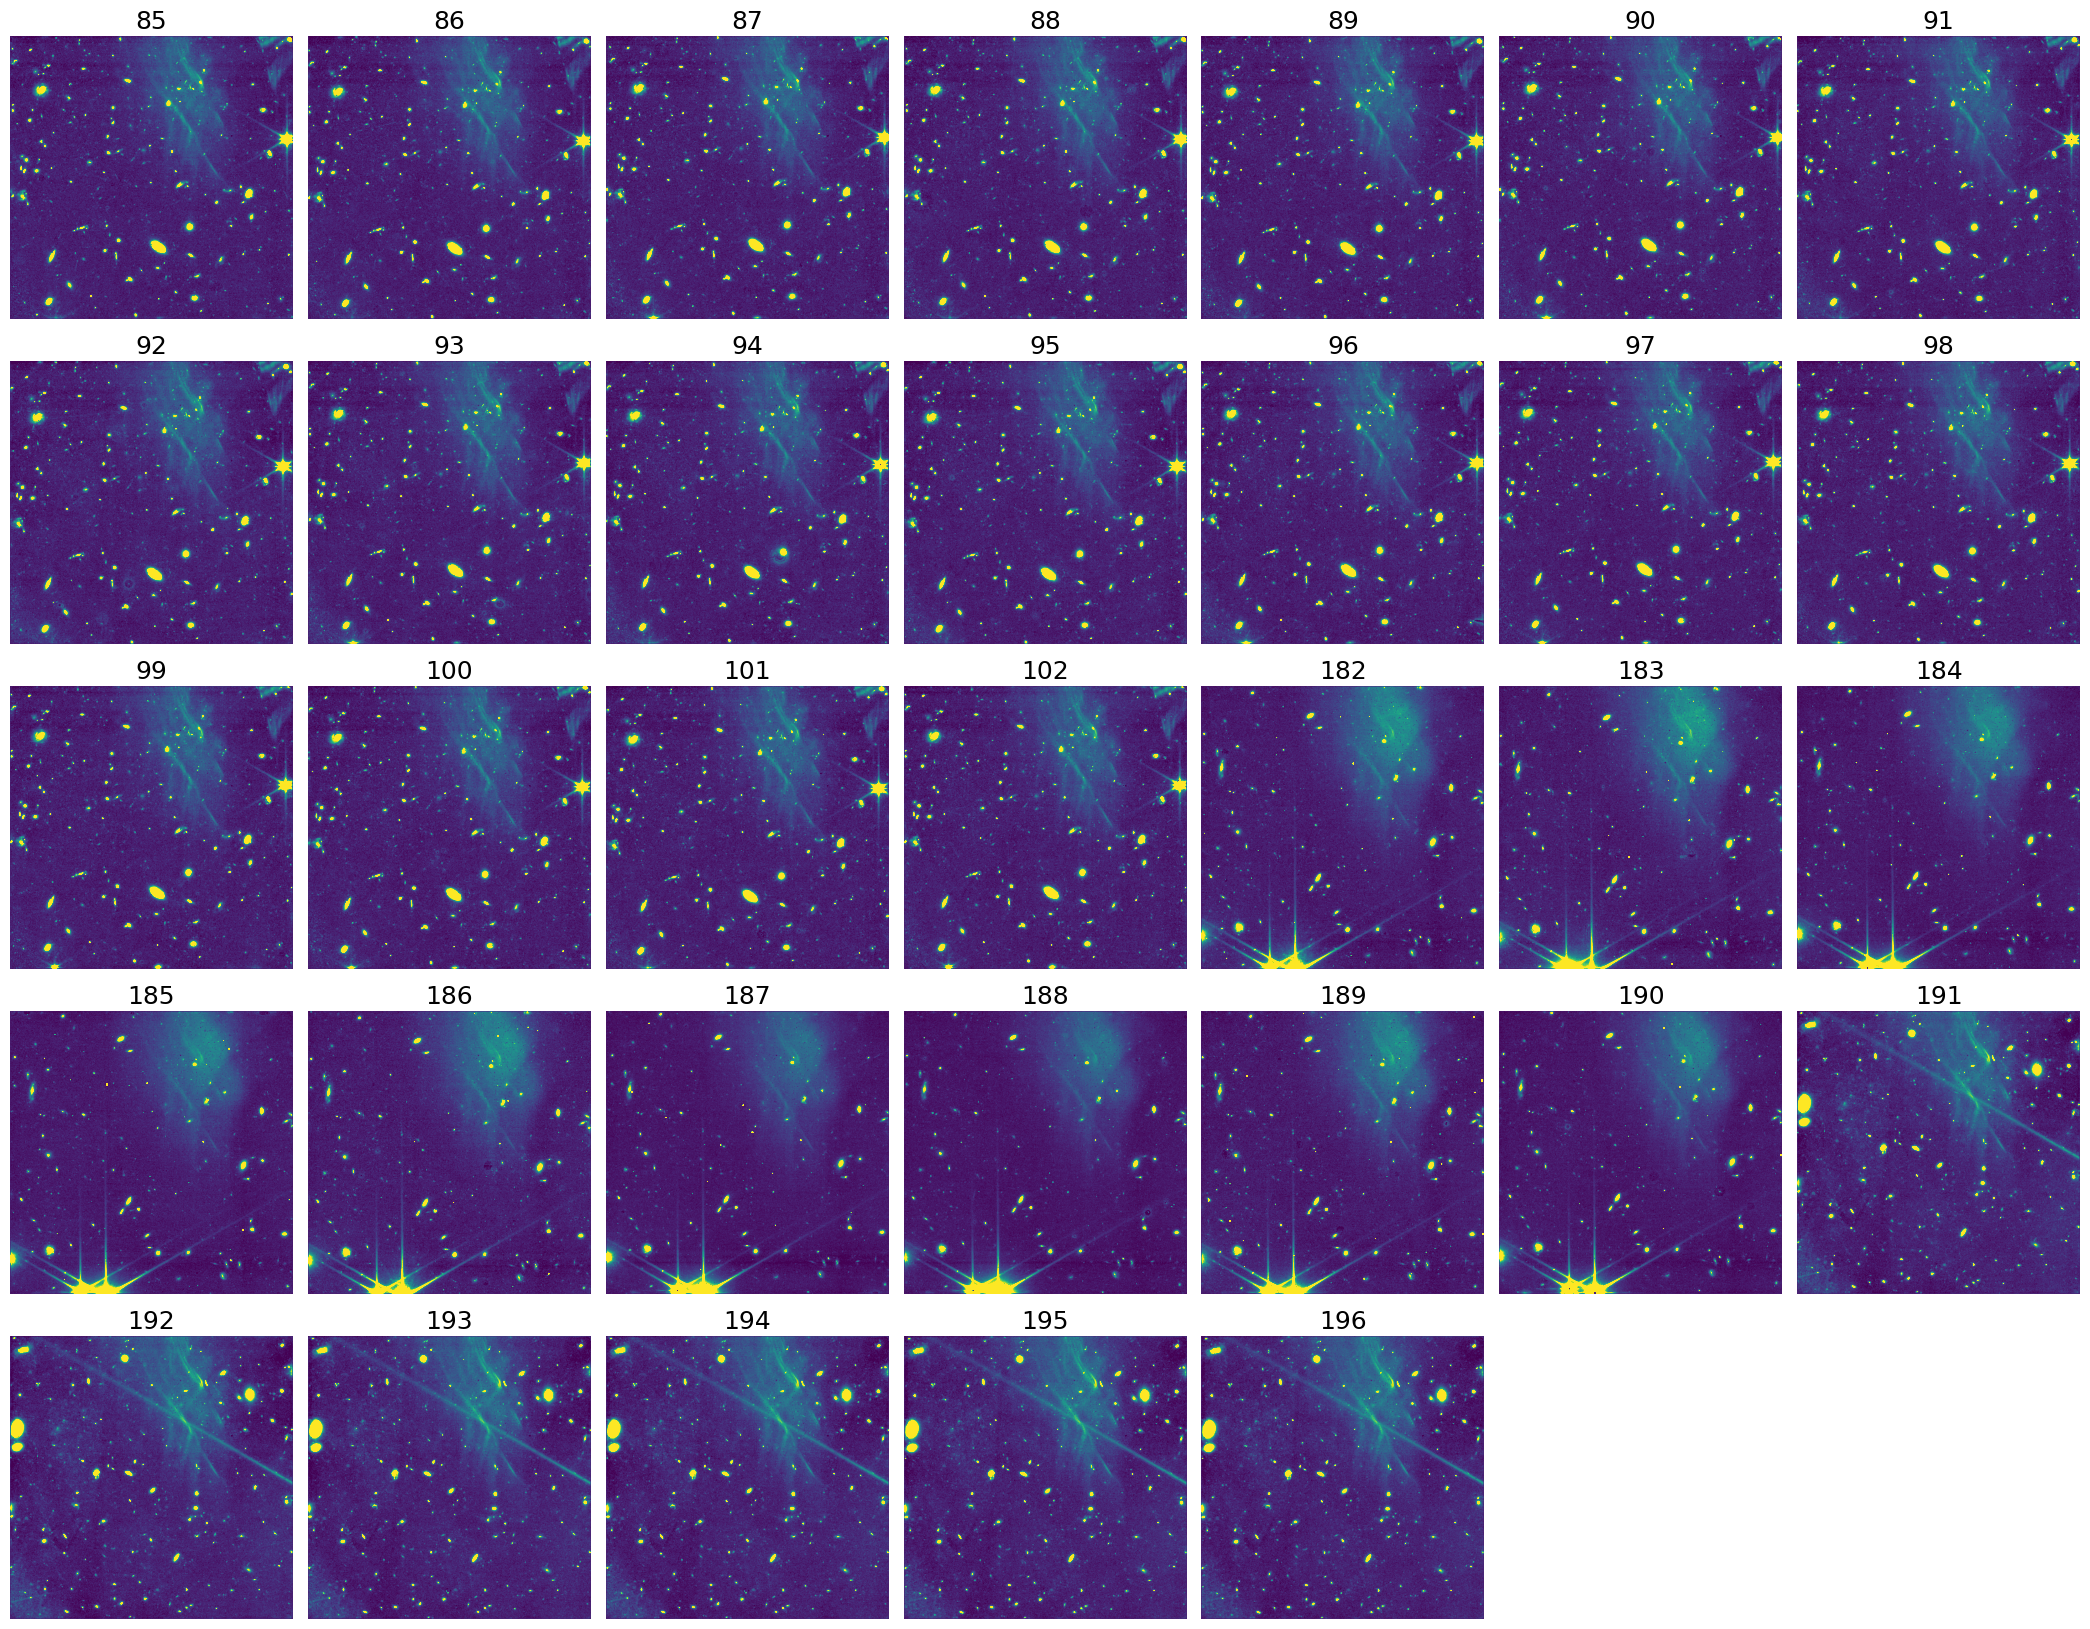

In [20]:
from utils import show_images
show_images(cal[outliers], title=outliers);

Fitting component 1/3 ... 

100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


Fitting component 2/3 ... 

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Fitting component 3/3 ... 

100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


Starting NMF with flat field iterations...


100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


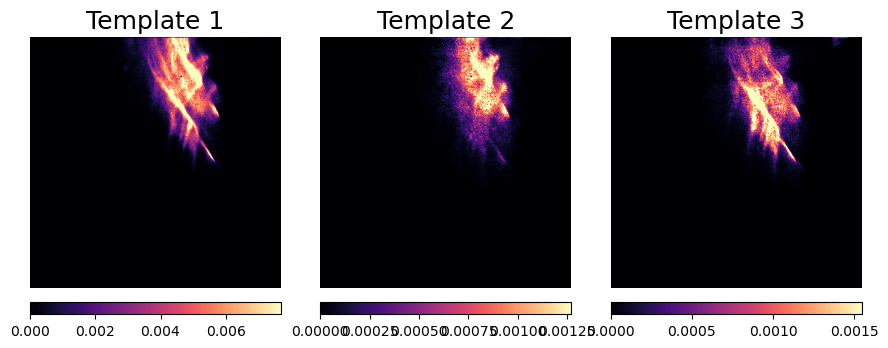

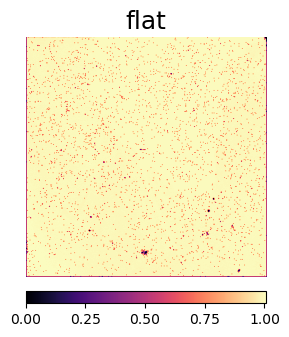

In [123]:
# def _nmf_with_flat(data, invVar, A, W, B, M, wisp_mask, n_iter=100, verbose=False, alpha=1):
#     """data: 2D array, shape (n_exp, n_pix)"""
#     data_invVar = data * invVar
#     A_mega, W_mega = np.hstack((A, B.reshape(-1, 1))), np.vstack((W, M.reshape(1, -1)))
#     n_exp = data.shape[0]

#     if verbose:
#         import tqdm
#         it_range = tqdm.tqdm(range(n_iter))
#     else:
#         it_range = range(n_iter)
        
#     for _ in it_range:
#         penalty_up   = alpha**2 * wisp_mask * n_exp
#         penalty_up   = np.vstack([np.zeros_like(W), penalty_up.reshape(1, -1)])

#         penalty_down = alpha**2 * wisp_mask * W_mega[-1] * n_exp
#         penalty_down = np.vstack([np.zeros_like(W), penalty_down.reshape(1, -1)]) 

#         W_mega_factor = (A_mega.T @ data_invVar + penalty_up) / (A_mega.T @ (invVar * (A_mega @ W_mega)) + 1e-10 + penalty_down)
#         W_mega_factor = np.clip(W_mega_factor, 1e-1, 1e1)
#         W_mega *= W_mega_factor
#         A_mega_factor = (data_invVar @ W_mega.T) / ((invVar * (A_mega @ W_mega)) @ W_mega.T + 1e-10)
#         A_mega_factor = np.clip(A_mega_factor, 1e-1, 1e1)
#         A_mega *= A_mega_factor

#         W_mega[:-1] *= np.median(A_mega[:, :-1], axis=0)[:, None]
#         A_mega[:, :-1] /= np.median(A_mega[:, :-1], axis=0)[None, :]
#         A_mega[:, -1] *= np.median(W_mega[-1, :])
#         W_mega[-1, :] /= np.median(W_mega[-1, :])

        
#     A, W = A_mega[:, :-1], W_mega[:-1, :]
#     B, M = A_mega[:, -1], W_mega[-1, :]

#     # A_med = np.median(A, axis=0)
#     # W, A = W * A_med[:, None], A / A_med[None, :]
#     return A, W, B, M, penalty_up, penalty_down

def _nmf_with_flat(data, invVar, A, W, B, M, wisp_mask, n_iter=100, verbose=False, alpha=1):
    eps = 1e-10
    alpha2 = float(alpha) ** 2
    n_exp = data.shape[0]

    data_invVar = data * invVar

    A_mega = np.hstack((A, B.reshape(-1, 1)))
    W_mega = np.vstack((W, M.reshape(1, -1)))

    wisp = np.median(A @ W, axis=0)
    wisp = wisp / np.median(wisp[wisp>0])

    base_penalty = alpha2 * wisp_mask * n_exp * (wisp + 1)
    zero_block = np.zeros_like(W)

    norm_every = 5

    if verbose:
        print("Starting NMF with flat field iterations...")
        import tqdm
        it_range = tqdm.tqdm(range(n_iter))
    else:
        it_range = range(n_iter)

    for it in it_range:
        model = A_mega @ W_mega 
        model_inv = invVar * model

        penalty_up_last = base_penalty
        penalty_down_last = base_penalty * W_mega[-1]

        penalty_up = np.vstack([zero_block, penalty_up_last.reshape(1, -1)])
        penalty_down = np.vstack([zero_block, penalty_down_last.reshape(1, -1)])

        num_W = A_mega.T @ data_invVar + penalty_up
        den_W = A_mega.T @ model_inv + penalty_down + eps

        W_mega_factor = num_W / den_W
        W_mega_factor = np.clip(W_mega_factor, 1e-1, 1e1)
        W_mega *= W_mega_factor

        model = A_mega @ W_mega
        model_inv = invVar * model

        num_A = data_invVar @ W_mega.T
        den_A = model_inv @ W_mega.T + eps

        A_mega_factor = num_A / den_A
        A_mega_factor = np.clip(A_mega_factor, 1e-1, 1e1)
        A_mega *= A_mega_factor

        if (it + 1) % norm_every == 0:
            A_med = np.median(A_mega[:, :-1], axis=0)
            W_mega[:-1] *= A_med[:, None]
            A_mega[:, :-1] /= A_med[None, :]

            W_last_med = np.median(W_mega[-1, :][~wisp_mask])
            A_mega[:, -1] *= W_last_med
            W_mega[-1, ~wisp_mask] /= W_last_med
        

    A, W = A_mega[:, :-1], W_mega[:-1, :]
    B, M = A_mega[:, -1], W_mega[-1, :]

    return A, W, B, M



from nmf_beta import vectorize_and_select_wisp_data, _nmf_iterative, _solve_amps_nnls
def nmf_iterative_fit_flat(data, err, mask, wisp_region, n_comp, bg, n_iter=100, alpha=10,
                            outliers=None, verbose=False):
    """data: 2D array, shape (n_exp, n_pix)"""
    idx = np.arange(data.shape[0])
    if outliers is not None:
        idx = np.delete(idx, outliers)
    data_valid, err_valid, mask_valid, bg_valid = data[idx], err[idx], mask[idx], bg[idx]
    _data, _invVar, _selected_pixels = vectorize_and_select_wisp_data(data_valid, err_valid, mask_valid, wisp_region)
    A, W0 = _nmf_iterative(_data, _invVar, n_comp, n_iter=n_iter, verbose=verbose)
    W0 = transform2D(W0, _selected_pixels)

    
    _data, _invVar, _wisp_region, _selected_pixels = vectorize_data(data_valid, err_valid, mask_valid, wisp_region)
    W = W0[:, _selected_pixels]
    
    B_init = np.ones(_data.shape[0])
    M_init = np.ones(_data.shape[1])
    A, W, B, M = _nmf_with_flat(_data+bg_valid[:, None], _invVar, A, W, B_init, M_init, _wisp_region, n_iter=n_iter, verbose=verbose, alpha=alpha)
    # wisp = transform2D(A @ W, _selected_pixels)
    # flat = transform2D(B @ M, _selected_pixels)
    A_all = np.zeros((data.shape[0], n_comp))
    A_all[idx] = A
    if outliers is not None:
        _data_invalid, _invVar_invalid, _, _ = vectorize_data(data[outliers], err[outliers], mask[outliers], wisp_region)
        A_all[outliers] = _solve_amps_nnls(_data_invalid, _invVar_invalid, W)

    wisp_temp = transform2D(W, _selected_pixels)
    flat_temp = transform2D(M, _selected_pixels)
    return A_all, wisp_temp, flat_temp


A_all, wisp_temp, flat_temp = nmf_iterative_fit_flat(cal, err, mask, wisp_region, n_comp=3, 
                                                     bg=bg, n_iter=100, outliers=outliers, verbose=True, alpha=1e2)

show_images(wisp_temp, title=[f'Template {i+1}' for i in range(wisp_temp.shape[0])], cmap='magma', show_colorbar=True);
show_images(flat_temp[None, :], title=['flat'], cmap='magma', show_colorbar=True);

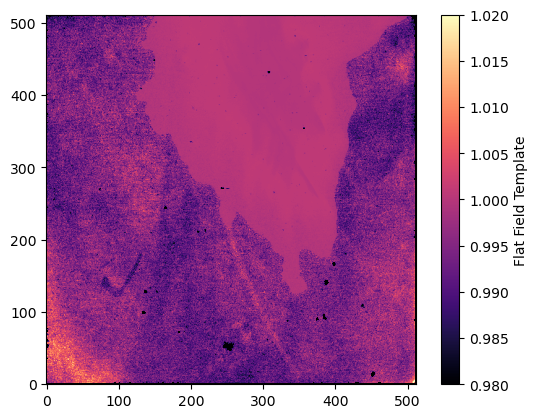

In [127]:
from postprocess import interpolate_wisp_nans
flat_temp = interpolate_wisp_nans(flat_temp[None, :], np.sum(mask, axis=0) >= cal.shape[0]-2)[0]
plt.imshow(flat_temp, cmap='magma', origin='lower', vmin=0.98, vmax=1.02)
plt.colorbar(label='Flat Field Template')

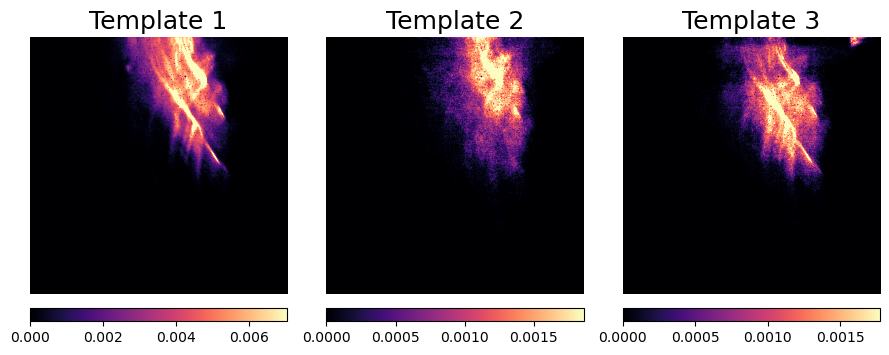

In [89]:
show_images(wisp_temp, title=[f'Template {i+1}' for i in range(wisp_temp.shape[0])], cmap='magma', show_colorbar=True);

/Users/zihaowu/Desktop/wisp_organized/make_template/postprocess.py:59: RuntimeWarning: divide by zero encountered in reciprocal
  noise_power = invVar**(-1)


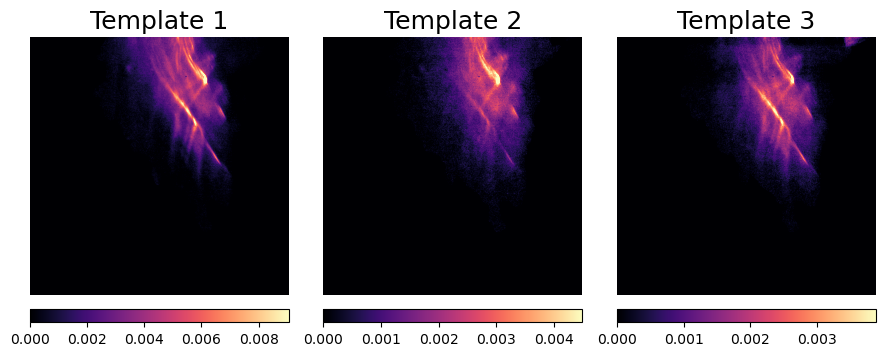

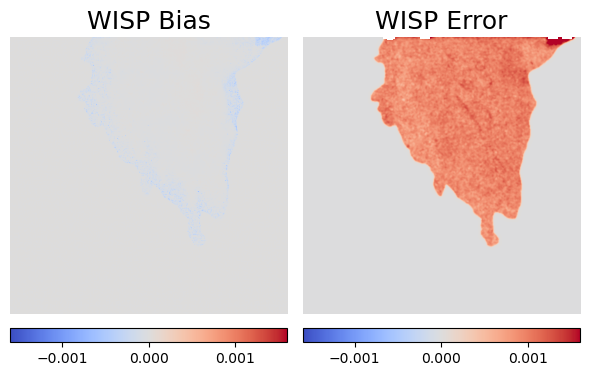

In [ ]:
# post-process templates
# from postprocess import interpolate_wisp_nans, estimate_errors
from scipy.ndimage import binary_fill_holes
from postprocess import interpolate_wisp_nans, estimate_errors
nan_pixels = np.sum(mask, axis=0) >= cal.shape[0]-2
templates = interpolate_wisp_nans(templates, nan_pixels)
residual = data - amps @ comps
wisp_bias, wisp_err = estimate_errors(residual, invVar, outliers, selected_pixels, nan_pixels)
primary = templates[0]
wisp_mask = np.zeros_like(primary, dtype=bool)
wisp_mask[selected_pixels] = True
wisp_mask = binary_fill_holes(wisp_mask)
high_snr_mask = primary > np.std((primary[primary>0]))

# show results
show_images(templates, title=[f'Template {i+1}' for i in range(templates.shape[0])], 
            cmap='magma', vlim=(1., 99.95), show_colorbar=True);
show_images([wisp_bias, wisp_err], title=['WISP Bias', 'WISP Error'], 
            cmap='coolwarm', vlim_value=(-0.0016, 0.0016), show_colorbar=True);

In [ ]:
# save templates
from astropy.io import fits
import os
output_folder = 'templates'
os.makedirs(output_folder, exist_ok=True)
hdu_list = fits.HDUList([fits.PrimaryHDU()])
for i in range(templates.shape[0]):
    hdu_list.append(fits.ImageHDU(templates[i], name=f'WISP_{i+1:02d}'))
hdu_list.append(fits.ImageHDU(wisp_mask.astype(int), name='MASK'))
hdu_list.append(fits.ImageHDU(high_snr_mask.astype(int), name='MASK_HSNR'))
hdu_list.append(fits.ImageHDU(wisp_bias, name='BIAS'))
hdu_list.append(fits.ImageHDU(wisp_err, name='ERR'))
hdu_list.writeto(f'templates/{DETECTOR}_{FILTER}.fits', overwrite=True)

In [ ]:
# from nmf import nmf_basic
# from preprocess import correct_1f_noise, estimate_1f_noise

# n_iter_1f = 3

# for it in range(n_iter_1f):
#     residual = data - amps @ comps
#     noise1f = estimate_1f_noise(residual, mask | wisp_mask[None, :], split_amplifier=True)

# # n_exp, n_pix = data.shape
# # data_corrected = np.zeros_like(data)
# # stripes_all = np.zeros_like(data)
# # return W, H, stripes_all


In [ ]:
residual.shape

(379, 77238)